<h1>Bike Sharing Dataset using Linear Regressor

<B>This is Supervised problem as the output datasets are provided and I used this to predict the future outcomes of target variable.
    
This is regression problem as dependent variable i.e. Bike Rental Count is continuous values or ordered whole values. Regression means to predict the output value using training data.



<B>Based on Bike Sharing dataset from UCI Machine Learning Repository
This notebook is based upon the hourly data file, i.e. hour.csv
This notebook showcases regression using Decision Trees



<h3>Problem Statement

Given the Bike Sharing dataset with hourly level information of bikes along with weather, User type Registered/Casual and other attributes, model a system which can predict the bike count.

<h1> Import required packages

In [1]:
%matplotlib inline
# data manuipulation
import numpy as np
import pandas as pd

# modeling utilities
from scipy import stats
#import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sn


sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [2]:
#Importing the dataset
stat = pd.read_csv('hour.csv')

In [3]:
#Shape of dataset
stat.shape

(17379, 17)

In [4]:
# top 3 rows from the dataset
stat.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/11,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1/1/11,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1/1/11,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


<h1> Preprocessing</h1>
<list>
<list>
Standarize column names
<list>
Typecast attributes
<list>
Encode Categoricals using One Hot Encoding

<h3> Standardize column names

In [5]:
stat.rename(columns = {'instant': 'rec_id',
                       'dteday':'datetime',
                       'holiday': 'is_holiday',
                       'workingday': 'is_workingday',
                       'weathersit': 'weather_condition',
                       'hum': 'humidity', 
                       'mnth': 'month',
                       'cnt': 'total_count',
                       'hr': 'hour',
                       'yr': 'year'}, inplace = True)

<h3> Typecast Attributes

In [6]:
#type casting the attributes
stat['datetime'] = pd.to_datetime(stat.datetime)#dae time conversion
# categorical variables
stat['season'] = stat.season.astype('category')
stat['is_holiday'] = stat.is_holiday.astype('category')
stat['weekday'] = stat.weekday.astype('category')
stat['weather_condition'] = stat.weather_condition.astype('category')
stat['is_workingday'] = stat.is_workingday.astype('category')
stat['month'] = stat.month.astype('category')
stat['year'] = stat.year.astype('category')
stat['hour'] = stat.hour.astype('category')

In [7]:
X = stat.iloc[:, 15:16].values
y = stat.iloc[:, 16].values

In [8]:
stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
rec_id               17379 non-null int64
datetime             17379 non-null datetime64[ns]
season               17379 non-null category
year                 17379 non-null category
month                17379 non-null category
hour                 17379 non-null category
is_holiday           17379 non-null category
weekday              17379 non-null category
is_workingday        17379 non-null category
weather_condition    17379 non-null category
temp                 17379 non-null float64
atemp                17379 non-null float64
humidity             17379 non-null float64
windspeed            17379 non-null float64
casual               17379 non-null int64
registered           17379 non-null int64
total_count          17379 non-null int64
dtypes: category(8), datetime64[ns](1), float64(4), int64(4)
memory usage: 1.3 MB


<h1> ONE HOT ENCODING - The Categorical Features

In [9]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
        column.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded

    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series

    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

<h1> Train-Test Split

In [10]:
X, X_test, y, y_test = train_test_split(stat.iloc[:,2:-1], stat.iloc[:,16], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


In [11]:
#np.array(stat.iloc[:,2:-1])
#list(stat.iloc[:,16])

In [12]:
y_test

,index,total_count
0,12830,425
1,8688,88
2,7091,4
3,12230,526
4,431,13
5,1086,32
6,11605,706
7,7983,26
8,10391,2
9,7046,21


In [13]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
#Predicting the Test Set results
y_pred = regressor.predict(X_test)

In [15]:
X.iloc[:, -2]

0          6
1         21
2        161
3          0
4        299
5         53
6          0
7          0
8         17
9        118
10         1
11         1
12         8
13         0
14        36
15        27
16         3
17        43
18        14
19        71
20         1
21        11
22        79
23         2
24         9
25        11
26         6
27        18
28        69
29         0
        ... 
11613    219
11614      2
11615      9
11616      0
11617      4
11618      2
11619      3
11620      1
11621      0
11622     45
11623     10
11624      0
11625      6
11626     23
11627      1
11628      3
11629      8
11630      9
11631      7
11632     19
11633     10
11634      2
11635     36
11636     10
11637      9
11638     30
11639    124
11640     26
11641      3
11642     33
Name: casual, Length: 11643, dtype: int64

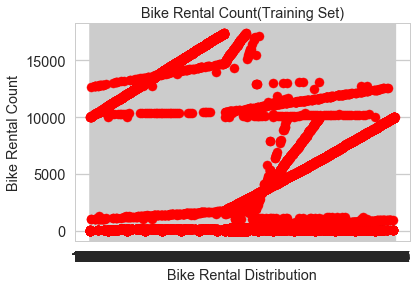

In [16]:
# Visualizing the Training set results
plt.scatter(y_test, y_pred, color = 'red')
#plt.plot(y_test, y_pred, color = 'blue')
plt.title('Bike Rental Count(Training Set)')
plt.xlabel('Bike Rental Distribution')
plt.ylabel('Bike Rental Count')
plt.show()

<h1> Normality Test

scipy.stats.probplot(x, sparams=(), dist='norm', fit=True, plot=None, rvalue=False)[source]
Calculate quantiles for a probability plot, and optionally show the plot.

Generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default). probplot optionally calculates a best-fit line for the data and plots the results using Matplotlib or a given plot function.

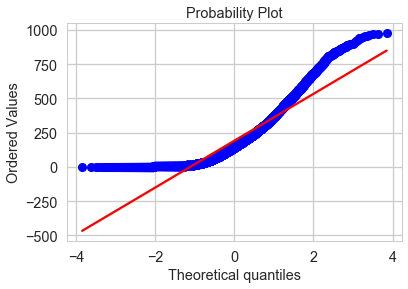

In [17]:
stats.probplot(y.iloc[:, 1], dist="norm", plot=plt)
plt.show()

In [18]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year', 'registered', 'casual']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [19]:
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [20]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 21)


In [21]:
print (y)

       index  total_count
0       5749           64
1       1843          106
2      13855          491
3       9723            4
4      10981          567
5       1285          183
6      16759            9
7       4303            1
8       6366          238
9       1941          248
10     16397           83
11      1091            7
12      6891          140
13        73            4
14      3397          160
15     14067          618
16      8604           95
17      4192          160
18     14875           45
19     14488          303
20      9149           21
21      5064           77
22      4387          596
23     17126          267
24     16539          181
25     12560           59
26     10269           94
27     14106          138
28     13139          369
29      7882            5
...      ...          ...
11613  14502          492
11614   8838            5
11615   3890           47
11616   3556            6
11617  11394           73
11618   1267           39
11619   1899

<h1> Linear Regression

In [22]:
X = train_df_new
y= y.total_count.values.reshape(-1,1)

In [23]:
X.shape, y.shape

((11643, 21), (11643, 1))

In [24]:
lin_reg = linear_model.LinearRegression()

<h1> Cross Validation

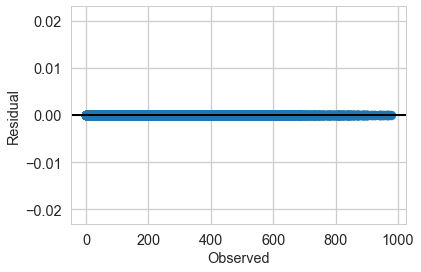

In [25]:
predicted = cross_val_predict(lin_reg, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [26]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')

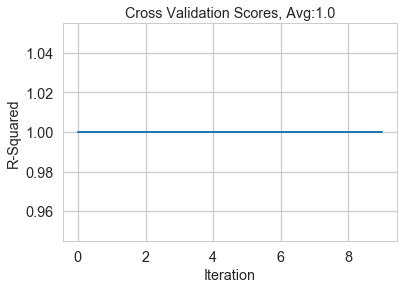

In [27]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [28]:
print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse_scores))

R-squared::[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
MSE::[-9.06551075e-27 -2.08297416e-26 -4.34504832e-27 -2.19529475e-26
 -1.34642653e-26 -2.07312461e-26 -3.05534343e-26 -6.14657672e-27
 -7.81166368e-27 -1.41125179e-26]
